In [15]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv 

from tqdm import tqdm
from tvtk.api import tvtk, write_data


In [16]:
# model_path = base_path + '/extrapolation_result.nf2'
# vtk_path = base_path + '/extrapolation_result.vtk'
model_path = '/home/tensor/workspace/pinn_study/_run/isee/dim256_bin2_pfTrue_ld0.1_lf0.1/extrapolation_result.nf2'
vtk_path = '/home/tensor/workspace/pinn_study/_run/isee/dim256_bin2_pfTrue_ld0.1_lf0.1/extrapolation_result_index.vtk'

if not os.path.exists(vtk_path):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    
    # from nf2.evaluation.unpack import load_cube
    # from nf2.evaluation.vtk import save_vtk
    # b = load_cube(model_path, device, progress=True)
    # save_vtk(b, vtk_path, 'B')

    state = torch.load(str(model_path), map_location=device)
    model = torch.nn.DataParallel(state['model'])

    cube_shape = state['cube_shape']
    z = cube_shape[2]
    coords = np.stack(np.mgrid[:cube_shape[0]:1, :cube_shape[1]:1, :z:1], -1)
    spatial_norm = 160
    coords = torch.tensor(coords / spatial_norm, dtype=torch.float32)
    coords_shape = coords.shape
    cube = []
    batch_size = 1000
    coords = coords.view((-1, 3))
    
    it = range(int(np.ceil(coords.shape[0] / batch_size)))
    for k in tqdm(it):
        coord = coords[k * batch_size: (k + 1) * batch_size]
        coord = coord.to(device)
        coord.requires_grad = True
        cube += [model(coord).detach().cpu()]
    cube = torch.cat(cube)
    cube = cube.view(*coords_shape).numpy()
    b_norm = 2500
    b = cube * b_norm    

    dim = b.shape[:-1]

    # ------ Idx -----------------------------------
    pts = np.stack(np.mgrid[0:dim[0], 0:dim[1], 0:dim[2]], -1).astype(np.float32)
    # ------ Idx -----------------------------------
    
    # ------ Mm ------------------------------------
    # x_pts = np.arange(dim[0]) * (Lx / (dim[0]-1))
    # y_pts = np.arange(dim[1]) * (Ly / (dim[1]-1))
    # data_z = np.arange(Nz)*dz
    # z_pts = np.arange(dim[2]) * ((data_z[:dim[2]][-1]) / (dim[2]-1))
    # pts = np.stack(np.meshgrid(x_pts, y_pts, z_pts, indexing='ij'), axis=-1)
    # ----------------------------------------------

    pts = pts.transpose(2, 1, 0, 3)
    pts = pts.reshape((-1, 3))
    vectors = b.transpose(2, 1, 0, 3)
    vectors = vectors.reshape((-1, 3))
    sg = tvtk.StructuredGrid(dimensions=dim, points=pts)
    sg.point_data.vectors = vectors
    sg.point_data.vectors.name = 'B'
    write_data(sg, str(vtk_path))

In [17]:
mesh = pv.read(vtk_path)

In [18]:
xindmax, yindmax, zindmax = mesh.dimensions
xcenter, ycenter, zcenter = mesh.center

mesh_g = mesh.compute_derivative(scalars='B')

def gradients_to_dict(arr):
    keys = np.array(
        ["dBx/dx", "dBx/dy", "dBx/dz", "dBy/dx", "dBy/dy", "dBy/dz", "dBz/dx", "dBz/dy", "dBz/dz"]
    )
    keys = keys.reshape((3,3))[:, : arr.shape[1]].ravel()
    return dict(zip(keys, mesh_g['gradient'].T))

gradients = gradients_to_dict(mesh_g['gradient'])

curlB_x = gradients['dBz/dy'] - gradients['dBy/dz']
curlB_y = gradients['dBx/dz'] - gradients['dBz/dx']
curlB_z = gradients['dBy/dx'] - gradients['dBx/dy']

curlB = np.vstack([curlB_x, curlB_y, curlB_z]).T

mesh.point_data['curlB'] = curlB
mesh

StructuredGrid (0x7fbe7a7fd4e0)
  N Cells:      5149215
  N Points:     5242880
  X Bounds:     0.000e+00, 2.550e+02
  Y Bounds:     0.000e+00, 1.270e+02
  Z Bounds:     0.000e+00, 1.590e+02
  Dimensions:   256, 128, 160
  N Arrays:     2

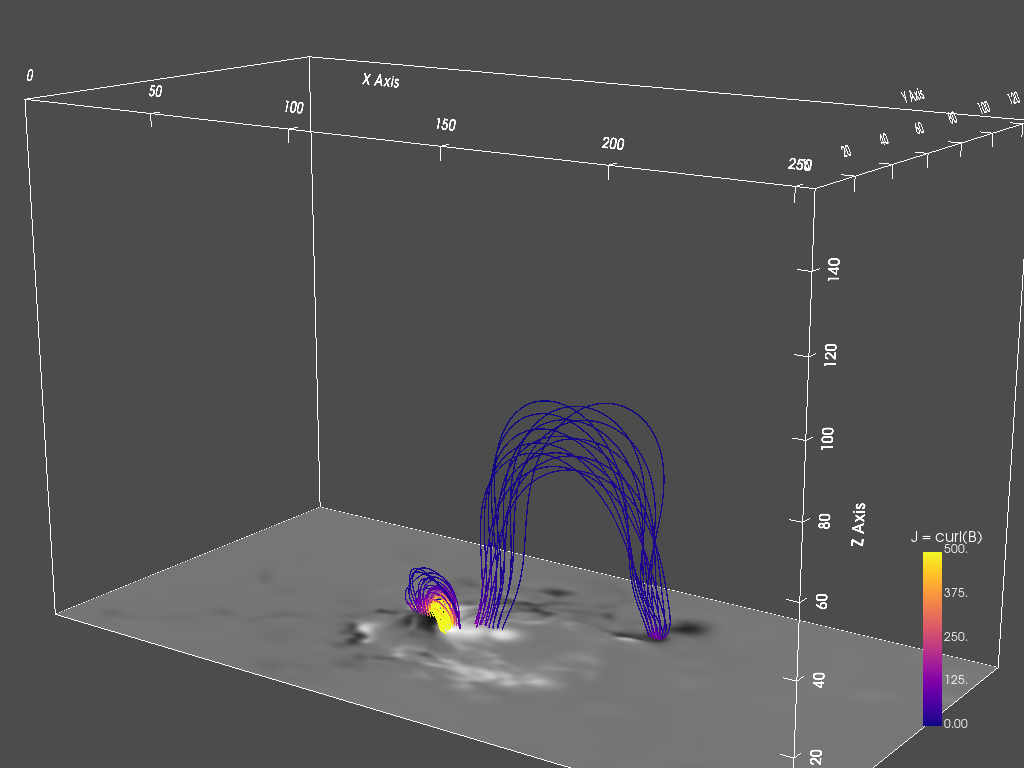

In [40]:
p = pv.Plotter()
p.add_mesh(mesh.outline())

#-----------------------
sargs_B = dict(
    title='Bz [G]',
    title_font_size=15,
    height=0.25,
    width=0.05,
    vertical=True,
    position_x = 0.05,
    position_y = 0.05,
)
dargs_B = dict(
    scalars='B', 
    component=2, 
    clim=(-3000, 3000), 
    scalar_bar_args=sargs_B, 
    show_scalar_bar=False, 
    lighting=False
)
p.add_mesh(mesh.extract_subset((0, xindmax, 0, yindmax, 0, 0)), 
           cmap='gray', **dargs_B)
#-----------------------

#-----------------------
sargs_J = dict(
    title='J = curl(B)',
    title_font_size=15,
    height=0.25,
    width=0.05,
    vertical=True,
    position_x = 0.9,
    position_y = 0.05,
)
dargs_J = dict(
    scalars='curlB', 
    clim=(0, 500),
    scalar_bar_args=sargs_J, 
    show_scalar_bar=True, 
    lighting=False
)
#-----------------------

def draw_streamlines(pts):
    stream, src = mesh.streamlines(
        return_source=True,
        # source_center=(120, 90, 0),
        # source_radius=5,
        # n_points=100,
        start_position = pts,
        integration_direction='both',
        # progress_bar=False,
        max_time=1000,
        # initial_step_length=0.001,
        # min_step_length=0.001,
        # max_step_length=2.0,
        # max_steps=999999,
        # terminal_speed = 1e-16,
        # max_error = 1e-6,
    )
    p.add_mesh(stream.tube(radius=0.2), 
            cmap='plasma', **dargs_J)

# stream, src = mesh.streamlines(
#     return_source=True,
#     source_center=(120, 100, 0),
#     source_radius=5,
#     n_points=100,
#     # start_position = (100, 80, 0),
#     integration_direction='both',
#     max_time=1000,
# )
# p.add_mesh(stream.tube(radius=0.2), 
#            cmap='coolwarm', **dargs_J)

# draw_streamlines((105, 80, 0))
# draw_streamlines((100, 80, 0))
# draw_streamlines((120, 80, 0))


# for i in np.arange(90, 100, 1):
#     for j in np.arange(85, 90, 1):
#         try: 
#             draw_streamlines((i, j, 0))
#         except:
#             print(i, j)

# for i in np.arange(92, 95, 1):
#     for j in np.arange(47, 50, 1):
#         try: 
#             draw_streamlines((i, j, 0))
#         except:
#             print(i, j)

# for i in np.arange(120, 125, 1):
#     for j in np.arange(47, 50, 1):
#         try: 
#             draw_streamlines((i, j, 0))
#         except:
#             print(i, j)

# for i in np.arange(157, 162, 1):
#     for j in np.arange(113, 117, 1):
#         try: 
#             draw_streamlines((i, j, 0))
#         except:
#             print(i, j)

for i in np.arange(90, 100, 1):
    for j in np.arange(65, 70, 1):
        try: 
            draw_streamlines((i, j, 0))
        except:
            print(i, j)

for i in np.arange(160, 165, 1):
    for j in np.arange(89, 92, 1):
        try: 
            draw_streamlines((i, j, 0))
        except:
            print(i, j)

# p.camera_position = 'xz'
p.camera.azimuth = -100
p.camera.elevation = -20
p.camera.zoom(1.5)
# p.camera_position = 'xy'
# p.show_grid()
p.show_bounds()
p.show(jupyter_backend='static')